In [1]:
using OrdinaryDiffEq, ParameterizedFunctions
using Optim, LsqFit 
using Plots, StatsPlots, LaTeXStrings
using DelimitedFiles, DataFrames
using Statistics
using Printf

In [2]:
ENV["COLUMNS"]=120
figdir = "figures/";

In [3]:
include("VirusLoadCurve.jl")
using .VirusLoadCurve

# Viral load data fitting



## Data set



In [7]:
filename = "../../data/Baccam2008/table1.csv"
temp = readdlm(filename, ',', Float64, '\n', header=true)
DATA = DataFrame(temp[1], Symbol.(temp[2][:]))
insertcols!(DATA, 2, "0" => 0.5)

,Patient,0,1,2,3,4,5,6,7,8
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,0.5,2.0,5.5,4.0,5.5,3.0,0.5,0.5,0.5
2,2.0,0.5,1.0,6.0,3.0,1.5,3.5,1.3,0.5,0.5
3,3.0,0.5,2.5,5.0,5.0,3.0,5.5,3.5,0.5,0.5
4,4.0,0.5,3.5,5.5,6.5,5.5,3.5,4.0,0.5,0.5
5,5.0,0.5,2.5,3.0,6.5,6.5,2.0,0.8,0.5,0.5
6,6.0,0.5,4.0,5.0,5.5,7.5,5.5,1.3,0.5,0.5


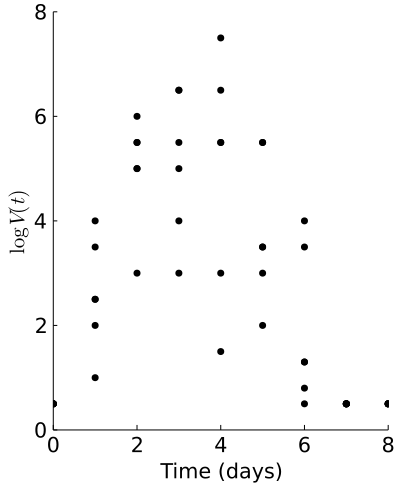

In [8]:
vlims = (0., 8)
plt = plot(legend=:none, ylims=vlims)
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    plot!(plt, data, size = (400, 500), color=:black)
end
display(plt)

## Fitting the standard virus load function to each individual in all groups (nasal swab)

Consider a virus load function with three main phases given by

$$V(t)=v_1(t)v_2(t)v_3(t),$$

where $v _1$ describes the initial growth phase between $a _1$ and $a _2$ , $v _2$ the intermediate slow decay
phase between $a _2$ and $b _1$, and $v _3$ the final decay phase between $b _1$ and $b _2$. These functions are given as sigmoid and exponential functions, respectively

$$
\begin{aligned}
v_1(t) & = 1 + \frac{V_{\max} - 1}{2} \left[ \tanh \left( \frac{6}{a_2 - a_1} \left( t - \frac{a_1 + a_2}{2} \right) \right) - \tanh  \left( -3\frac{a_2 + a_1}{a_2 - a_1} \right) \right] \\
v_2(t) & = (1 - H(t - a_2)) + H(t - a_2)e^{-\alpha(t - a_2)} \\
v_3(t) & = 1 - \frac{1 - V_{\min}}{2} \left[ \tanh \left( \frac{6}{b_2 - b_1} \left( t - \frac{b_1 + b_2}{2} \right) \right) - \tanh  \left( -3\frac{b_2 + b_1}{b_2 - b_1} \right) \right],
\end{aligned}
$$

where $H(t)$ denotes the Heaviside function.

In [9]:
results = []
tdata = parse.(Float64, names(DATA)[2:end])
for k ∈ 1:size(DATA, 1)
    vdata = Array(DATA[k, 2:end])
    data = VirusLoadCurve.VirusLoadData(tdata, vdata)
    resultVLF = VirusLoadCurve.fitVLF(data; ϵ=0.2)
    push!(results, resultVLF)
end

Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:25
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 331 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:13
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 46325 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:23
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 5196 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:13
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 989 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:14
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 1490 (out of 1000000 testted)


Fitting the VLF to data 100%|███████████████████████████| Time: 0:00:10
Finding possible parameter values 100%|█████████████████| Time: 0:00:07


Number of possible parameters found: 4683 (out of 1000000 testted)


In [11]:
using JLD2, FileIO
# save("Baccam2008Results.jld2", Dict("results" => results))
results = load("Baccam2008Results.jld2", "results");

In [12]:
io = IOBuffer(append=true)
function param_extrema(result)
    param_array = result.param_array
    param = result.fit.param
    if length(param_array)==0 return (param, param) end
    array = map(x -> map(y -> y[x], param_array), 1:length(param_array[1]))
    param_lower = map(minimum, array)
    param_upper = map(maximum, array)
    return (param_lower, param_upper)
end
print(io, @sprintf "\nData & \$\\log V_{\\max}\$ & \$a_1\$ & \$a_2\$ & \$\\alpha\$ & \$b_1\$ & \$b_2\$ & RSS \\\\ \n")
function VLFResultsLatex(dataname, result)
    print(io, @sprintf "%s & " dataname)
#     print(io, @sprintf "%.2f \$\\cdot 10^{%d}\$ & " 10^rem(result.fit.param[6], 1) floor(result.fit.param[6]))
    print(io, @sprintf "%.2f & " result.fit.param[6])
    print(io, @sprintf "%.2f & " result.fit.param[1])
    print(io, @sprintf "%.2f & " result.fit.param[2])
    print(io, @sprintf "%.2f & " result.fit.param[5])
    print(io, @sprintf "%.2f & " result.fit.param[3])
    print(io, @sprintf "%.2f & " result.fit.param[4])
    print(io, @sprintf "%.3f \\\\ \n" sum(abs2, result.fit.resid))
    lower, upper = param_extrema(result)
    print(io, @sprintf "  & ")
#     print(io, @sprintf "(%.2f \$\\cdot 10^{%d}\$, %.2f \$\\cdot 10^{%d}\$) & " 10^rem(lower[6], 1) floor(lower[6]) 10^rem(upper[6], 1) floor(upper[6]))
    print(io, @sprintf "(%.2f, %.2f) & " lower[6] upper[6])
    print(io, @sprintf "(%.2f, %.2f) & " lower[1] upper[1])
    print(io, @sprintf "(%.2f, %.2f) & " lower[2] upper[2])
    print(io, @sprintf "(%.2f, %.2f) & " lower[5] upper[5])
    print(io, @sprintf "(%.2f, %.2f) & " lower[3] upper[3])
    print(io, @sprintf "(%.2f, %.2f) & " lower[4] upper[4])
    print(io, @sprintf "\$\\leq\$ %.3f \\\\ \n" (1.0+0.1)*sum(abs2, result.fit.resid))
end

VLFResultsLatex (generic function with 1 method)

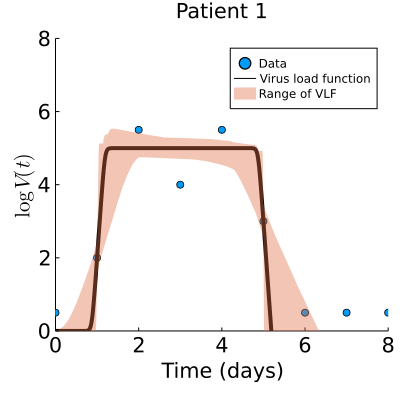

Patient 1: 
RSS = 1.50000e+00
a₁ = 1.0250079459520953, CI=(0.9956867008587537, 1.2147905446708342)
a₂ = 1.352335255459819, CI=(1.0649391130141912, 2.6540113421709854)
b₁ = 4.708737893383185, CI=(2.985083290836048, 4.975011199017643)
b₂ = 5.038620143887595, CI=(5.0020120972775475, 5.545303432000389)
α = 1.0e-8, CI=(1.0e-8, 0.7558172722001874)
logVmax = 4.999999999936722, CI=(4.749105209991554, 5.533614612548282)


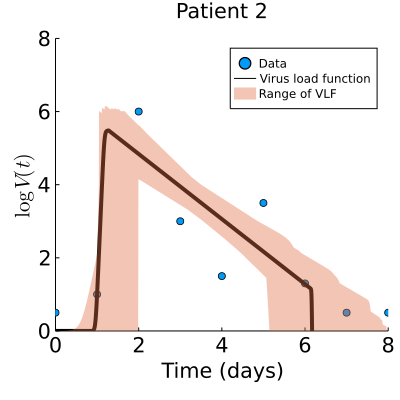




Patient 2: 
RSS = 6.45100e+00
a₁ = 1.0746618955313347, CI=(0.9830718172145217, 1.9918586128693736)
a₂ = 1.2769521085133877, CI=(1.0023771302536808, 2.4288111199738114)
b₁ = 6.131235524927647, CI=(2.9599215139528527, 7.999821058362809)
b₂ = 6.186005263065741, CI=(5.020140305873095, 7.999991777231211)
α = 2.0493007327859503, CI=(1.0017613435858117, 2.8703149472032248)
logVmax = 5.4835126234483385, CI=(4.051973550945085, 6.653974604602081)


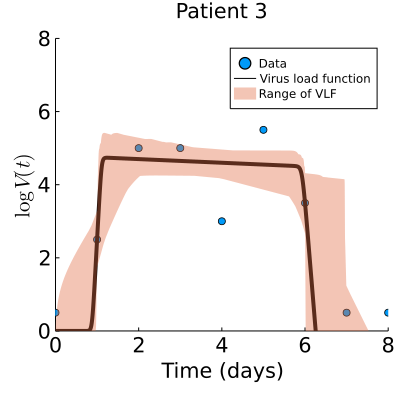




Patient 3: 
RSS = 3.67500e+00
a₁ = 0.9823361551511255, CI=(0.3575602766875007, 1.1373967497854818)
a₂ = 1.2321387171766578, CI=(1.0303483251715235, 3.6464736067824752)
b₁ = 5.741576794633397, CI=(4.103504591082277, 6.951899791747088)
b₂ = 6.119885093607538, CI=(6.006062005066979, 7.059955746376762)
α = 0.1151292547147027, CI=(2.0617280387352777e-5, 0.999938269649252)
logVmax = 4.738393064203089, CI=(4.250197233115475, 5.50798799648909)


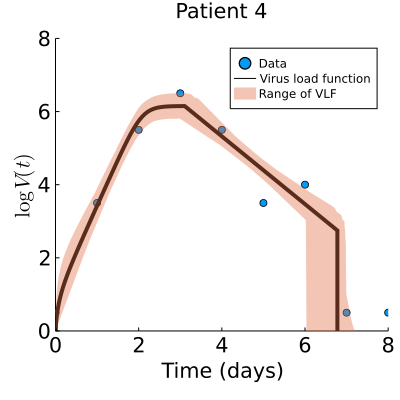




Patient 4: 
RSS = 1.30353e+00
a₁ = 1.047819886267751, CI=(0.7545948756438168, 1.260748283888303)
a₂ = 3.106189972036446, CI=(2.8031477489688883, 3.547536624181501)
b₁ = 6.778869084599372, CI=(5.084896322987875, 6.97052382733371)
b₂ = 6.778869084599372, CI=(6.031490933303957, 7.361471240279645)
α = 2.134368226455971, CI=(1.6020722654371278, 2.752933527998955)
logVmax = 6.151081813587946, CI=(5.8063588577176635, 6.504911937282801)


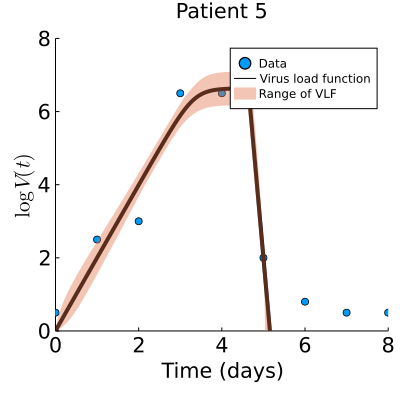




Patient 5: 
RSS = 1.69980e+00
a₁ = 2.018654275450731, CI=(1.7372922914699596, 2.2428197373980425)
a₂ = 4.640012906231406, CI=(4.580428534159301, 4.703725761767237)
b₁ = 6.350033850097594, CI=(4.600595195126185, 7.999681582930894)
b₂ = 6.350033850097594, CI=(5.046299740783384, 7.999945134588698)
α = 29.631787705371497, CI=(28.20481808595563, 31.629773984999122)
logVmax = 6.632853016695762, CI=(6.165501653807277, 7.093800167688364)


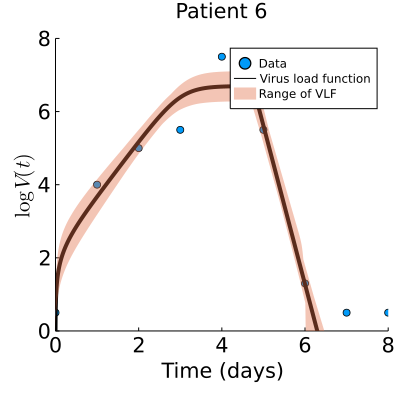




Patient 6: 
RSS = 1.60649e+00
a₁ = 1.2706579948446484, CI=(0.723599887502999, 1.6765510043820642)
a₂ = 4.750198284960417, CI=(4.57330858021702, 4.905866160906294)
b₁ = 6.960997623366845, CI=(4.723588510897763, 7.998937155168233)
b₂ = 6.960997623366845, CI=(6.0282663681576105, 7.999995672340116)
α = 9.983405061234102, CI=(8.537681742653511, 11.400056988876802)
logVmax = 6.696302695300956, CI=(6.272450441463825, 7.124788334698373)



Patient 1 & 5.00 & 1.03 & 1.35 & 0.00 & 4.71 & 5.04 & 1.500 \\ 
  & (4.75, 5.53) & (1.00, 1.21) & (1.06, 2.65) & (0.00, 0.76) & (2.99, 4.98) & (5.00, 5.55) & $\leq$ 1.650 \\ 
Patient 2 & 5.48 & 1.07 & 1.28 & 2.05 & 6.13 & 6.19 & 6.451 \\ 
  & (4.05, 6.65) & (0.98, 1.99) & (1.00, 2.43) & (1.00, 2.87) & (2.96, 8.00) & (5.02, 8.00) & $\leq$ 7.096 \\ 
Patient 3 & 4.74 & 0.98 & 1.23 & 0.12 & 5.74 & 6.12 & 3.675 \\ 
  & (4.25, 5.51) & (0.36, 1.14) & (1.03, 3.65) & (0.00, 1.00) & (4.10, 6.95) & (6.01, 7.06) & $\leq$ 4.043 \\ 
Patient 4 & 6.15 & 1.05 & 3.11 & 2.1

In [17]:
cases = "Patient ".*string.(Int.(DATA[:, 1]))
filename = "Baccam2006-"
for (resultVLF, case) ∈ zip(results, cases)
    println(case*": ")
    summary(resultVLF)
    VLFResultsLatex(case, resultVLF)
    pt = plot(resultVLF.data, size = (400, 400))
    plot!(pt, resultVLF)
    ylims!(pt, vlims)
    title!(pt, case)
    savefig(figdir*filename*replace(case, " " => "-")*".png")
    savefig(figdir*filename*replace(case, " " => "-")*".pdf")
    display(pt)
    println("\n\n")
end
print(read(io, String))
print(read(io, String))

In [15]:
function Boxplots(results)
    ndata = length(results)
    params = []
    for resultVLF ∈ results
        params = vcat(params, resultVLF.fit.param)
    end
    params = reshape(params, (6, ndata))
    param_names = results[1].names
    pt1 = plot(yaxis=("Time (days)", extrema(params[1:4, :]) .+ (-0.5, 0.5), font(14)), 
        xaxis=("Parameter", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    [boxplot!(pt1, repeat([param_names[i]], ndata), params[i, :], fillalpha=0.7, lw=2, color=1) for i = 1:4]
    [dotplot!(pt1, repeat([param_names[i]], ndata), params[i, :], marker=(:black, stroke(0))) for i = 1:4]
    pt2 = twinx()
    plot!(pt2, yaxis=("Decay rate (1/days)", extrema(params[5, :]) .+ (-0.2, 0.2), font(14)), 
        xaxis=("", font(14)), 
        grid=false, legend=false, left_margin = 5Plots.mm, right_margin = 16Plots.mm)
    boxplot!(pt2, repeat([param_names[5]], ndata), params[5, :], fillalpha=0.7, lw=2, color=2)
    dotplot!(pt2, repeat([param_names[5]], ndata), params[5, :], marker=(:black, stroke(0)))
    pt1
end

Boxplots (generic function with 1 method)

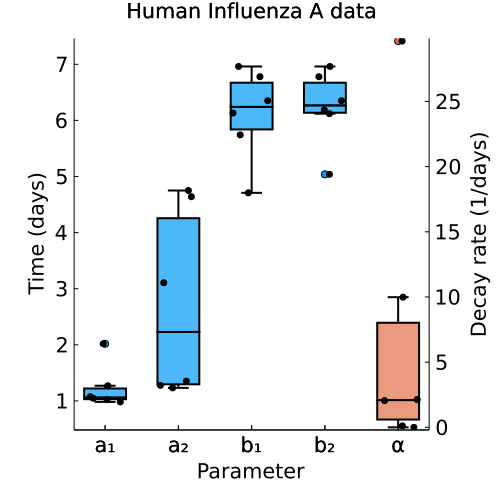

In [18]:
text_data = "Human Influenza A data"
text_file = "Baccam2006-Boxplot"
pt = Boxplots(results)
plot!(title = text_data, size=(500, 500))
savefig(figdir*text_file*".pdf")
savefig(figdir*text_file*".png")
display(pt)